# 🛰️ Satellite City Analyzer

Classify land cover in any Italian city using Sentinel-2 satellite imagery.

**Steps:**
1. Select a city
2. Load satellite data
3. Run classification
4. Visualize results

In [1]:
# Setup
import sys
from pathlib import Path

# Add src to path
PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT / "src"))

import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from satellite_analysis.utils import AreaSelector
from satellite_analysis.analyzers.classification import ConsensusClassifier

print("✅ Setup complete")

✅ Setup complete


In [2]:
# Select city
CITY = "rome"  # Change to: milan, florence, venice, turin, naples, bologna, genoa

# Check for data
data_dir = PROJECT_ROOT / "data" / "cities" / CITY / "bands"
if not data_dir.exists():
    data_dir = PROJECT_ROOT / "data" / "processed" / f"{CITY}_centro"

if data_dir.exists():
    print(f"✅ Found data for {CITY} at {data_dir}")
    print(f"   Files: {[f.name for f in data_dir.glob('*.tif')]}")
else:
    print(f"❌ No data found for {CITY}")
    print(f"   Run: python scripts/analyze_city.py --city {CITY}")

✅ Found data for rome at c:\TEMP_1\satellite_git_vt\satellite_git\data\cities\rome\bands
   Files: ['B02.tif', 'B03.tif', 'B04.tif', 'B08.tif']


In [3]:
# Load satellite bands
bands_needed = ['B02', 'B03', 'B04', 'B08']  # Blue, Green, Red, NIR
bands = {}

for band_name in bands_needed:
    band_path = data_dir / f"{band_name}.tif"
    with rasterio.open(band_path) as src:
        bands[band_name] = src.read(1).astype(np.float32)

print(f"✅ Loaded {len(bands)} bands")
print(f"   Image size: {bands['B02'].shape}")

✅ Loaded 4 bands
   Image size: (3006, 2980)


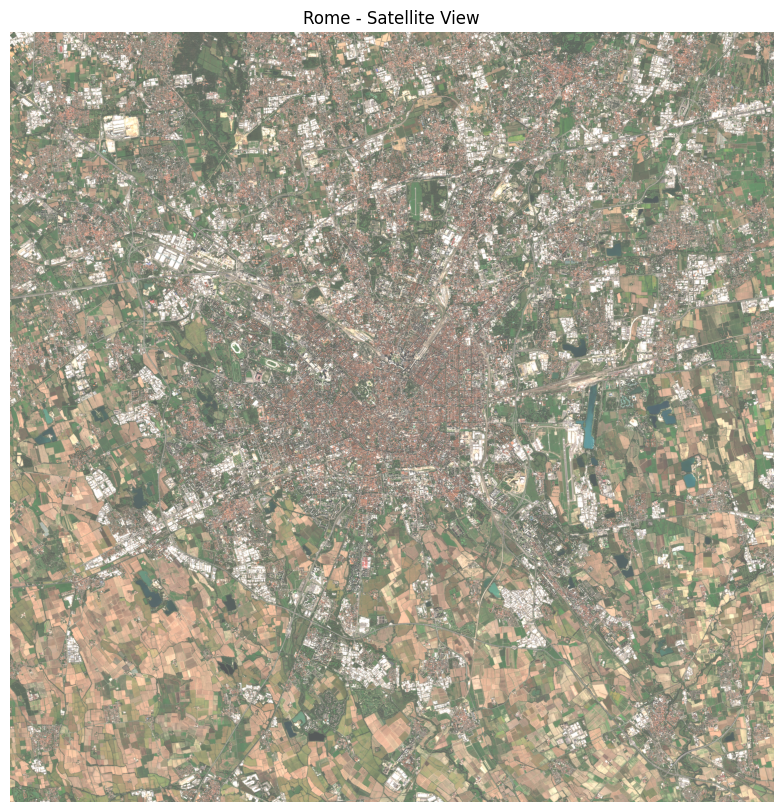

In [4]:
# Show RGB preview
red = np.clip(bands['B04'] / 3000, 0, 1)
green = np.clip(bands['B03'] / 3000, 0, 1)
blue = np.clip(bands['B02'] / 3000, 0, 1)
rgb = np.stack([red, green, blue], axis=-1)

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title(f"{CITY.title()} - Satellite View")
plt.axis('off')
plt.show()

In [8]:
# Run classification
band_stack = np.stack([bands['B02'], bands['B03'], bands['B04'], bands['B08']], axis=-1)

# Create band index mapping
band_indices = {
    'B02': 0,  # Blue
    'B03': 1,  # Green
    'B04': 2,  # Red
    'B08': 3   # NIR
}

classifier = ConsensusClassifier(n_clusters=6)
labels, confidence, uncertainty_mask, stats = classifier.classify(
    band_stack, 
    band_indices, 
    has_swir=False
)

print(f"✅ Classification complete")
print(f"   Classes found: {np.unique(labels)}")
print(f"   Average confidence: {confidence.mean():.2%}")
print(f"   Agreement: {stats['agreement_pct']:.1f}%")

c:\TEMP_1\satellite_git_vt\satellite_git\src\satellite_analysis\analyzers\classification\consensus_classifier.py:414: RuntimeWarning: invalid value encountered in divide
  (nir - red) / (nir + red),
c:\TEMP_1\satellite_git_vt\satellite_git\src\satellite_analysis\analyzers\classification\consensus_classifier.py:421: RuntimeWarning: invalid value encountered in divide
  (green - nir) / (green + nir),
c:\TEMP_1\satellite_git_vt\satellite_git\src\satellite_analysis\analyzers\classification\consensus_classifier.py:426: RuntimeWarning: divide by zero encountered in divide
  urban_idx = np.where(nir != 0, red / nir, 0)
c:\TEMP_1\satellite_git_vt\satellite_git\src\satellite_analysis\analyzers\classification\consensus_classifier.py:426: RuntimeWarning: invalid value encountered in divide
  urban_idx = np.where(nir != 0, red / nir, 0)


✅ Classification complete
   Classes found: [0 1 2 3 5]
   Average confidence: 62.69%
   Agreement: 57.3%


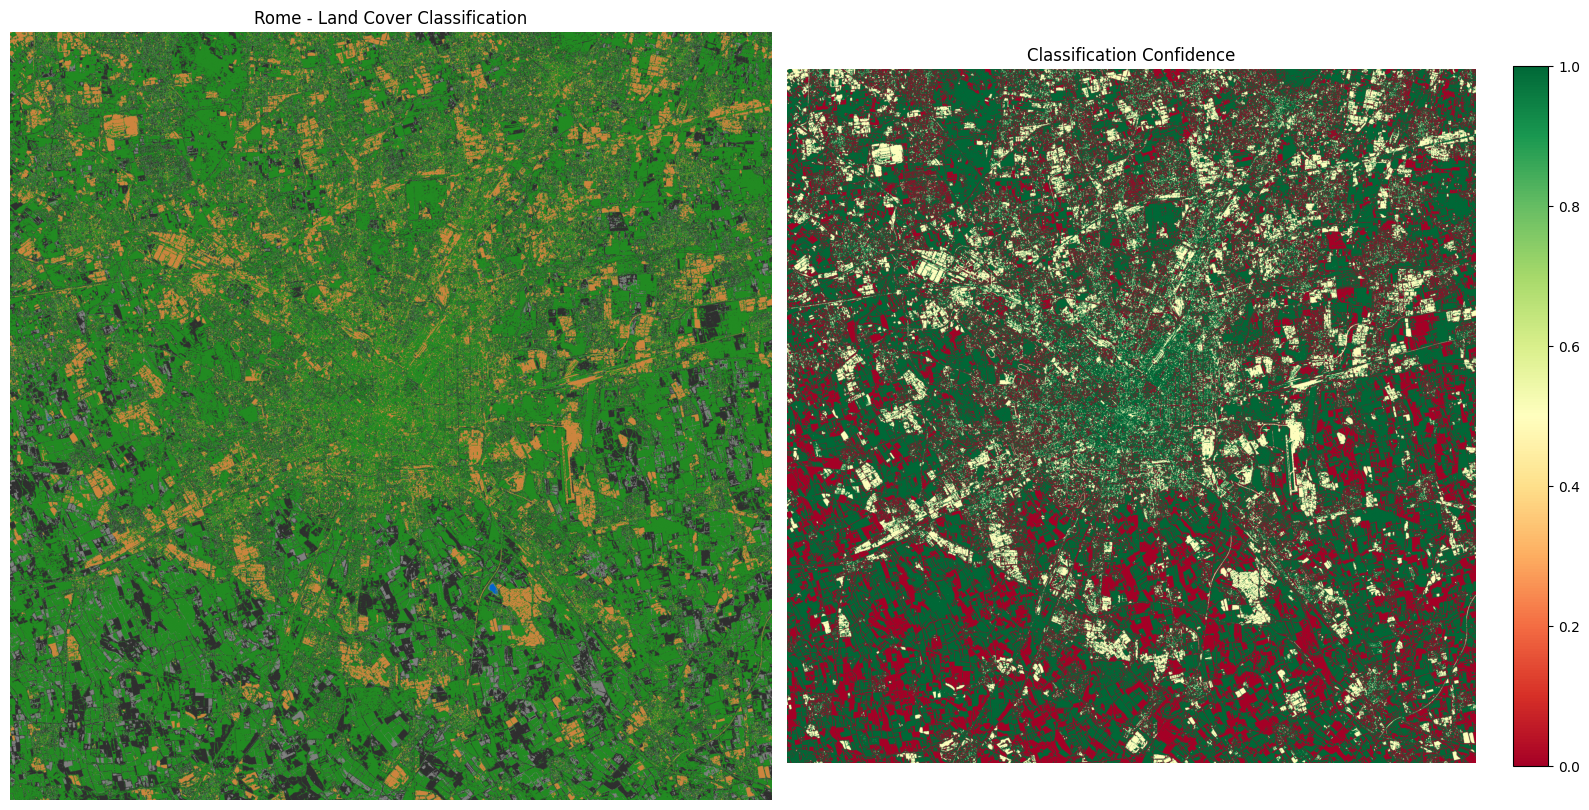

In [9]:
# Visualize results
CLASSES = {
    0: ('Water', '#0066CC'),
    1: ('Vegetation', '#228B22'),
    2: ('Bare Soil', '#CD853F'),
    3: ('Urban', '#808080'),
    4: ('Bright Surfaces', '#FFD700'),
    5: ('Shadows/Mixed', '#2F2F2F'),
}

colors = [CLASSES[i][1] for i in range(6)]
cmap = ListedColormap(colors)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Classification map
axes[0].imshow(labels, cmap=cmap, vmin=0, vmax=5)
axes[0].set_title(f"{CITY.title()} - Land Cover Classification")
axes[0].axis('off')

# Confidence map
im = axes[1].imshow(confidence, cmap='RdYlGn', vmin=0, vmax=1)
axes[1].set_title("Classification Confidence")
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

In [10]:
# Class distribution
unique, counts = np.unique(labels, return_counts=True)
total = counts.sum()

print(f"\n📊 Land Cover Distribution for {CITY.title()}\n")
print("-" * 40)
for cls_id, count in zip(unique, counts):
    name, color = CLASSES[cls_id]
    pct = count / total * 100
    bar = "█" * int(pct / 2)
    print(f"{name:20s} {pct:5.1f}% {bar}")


📊 Land Cover Distribution for Rome

----------------------------------------
Water                  0.0% 
Vegetation            57.3% ████████████████████████████
Bare Soil             10.7% █████
Urban                  8.8% ████
Shadows/Mixed         23.1% ███████████


In [11]:
# Save results (optional)
output_dir = PROJECT_ROOT / "data" / "cities" / CITY / "analysis"
output_dir.mkdir(parents=True, exist_ok=True)

np.save(output_dir / "labels.npy", labels)
np.save(output_dir / "confidence.npy", confidence)

print(f"✅ Results saved to {output_dir}")

✅ Results saved to c:\TEMP_1\satellite_git_vt\satellite_git\data\cities\rome\analysis
